# 이미지분석_사진유사도비교_서비스_mediapipe_deepface

In [1]:
import urllib
import cv2
import math
import matplotlib.pyplot as plt
import requests

In [2]:
# !pip install mediapipe

In [3]:
# 이미지 유사도 분석 모델 다운로드
#!wget -O embedder.tflite -q https://storage.googleapis.com/mediapipe-models/image_embedder/mobilenet_v3_small/float32/1/mobilenet_v3_small.tflite

import urllib.request
url  = "https://storage.googleapis.com/mediapipe-models/image_embedder/mobilenet_v3_small/float32/1/mobilenet_v3_small.tflite"
urllib.request.urlretrieve(url, "embedder.tflite")
print("다운로드 완료")

다운로드 완료


In [4]:
image_filenames = ['burger.jpg', 'burger_crop.jpg']

for name in image_filenames:
    url = f"https://storage.googleapis.com/mediapipe-assets/{name}"
    urllib.request.urlretrieve(url, name)

In [5]:
desired_height = 480
desired_width = 480

In [6]:
def resize_and_show(image):
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (desired_width, math.floor(h/(w/desired_width))))
    else:
        img = cv2.resize(image, (math.floor(w/(h/desired_height)), desired_height))
    return img


burger.jpg


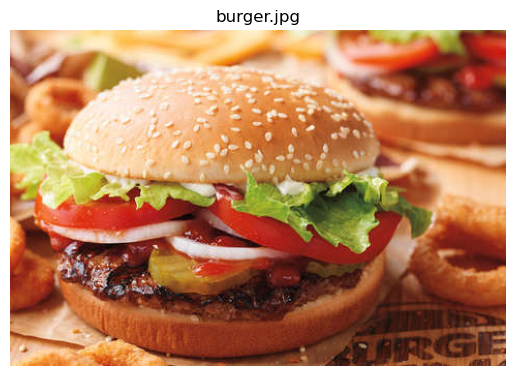

burger_crop.jpg


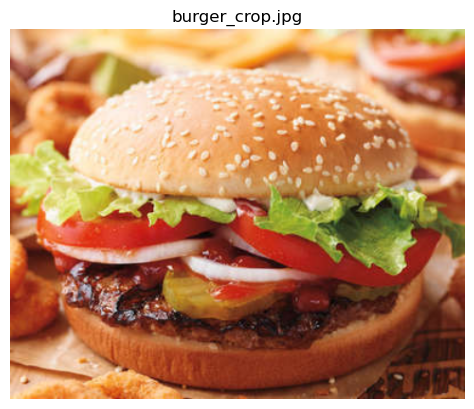

In [7]:
# 이미지 미리보기
images = {name: cv2.imread(name) for name in image_filenames}

for name, image in images.items():
    print(name)
    resize_image = resize_and_show(image)
    plt.imshow(cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.axis('off')
    plt.show()


# Mediapipe 모델 활용 유사도 분석

In [29]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from pathlib import Path

In [37]:
# 모델 파일을 바이너리로 읽음
with open("C:/fintech/06_Deep_Learning/embedder.tflite", "rb") as f:
    model_bytes = f.read()

In [38]:
base_options = python.BaseOptions(model_asset_buffer=model_bytes)
l2_normalize = True
quantize = True
options = vision.ImageEmbedderOptions(
        base_options=base_options, l2_normalize=l2_normalize, quantize=quantize
        )

# create image embedder
with vision.ImageEmbedder.create_from_options(options) as embedder:
    first_image = mp.Image.create_from_file(image_filenames[0])
    second_image = mp.Image.create_from_file(image_filenames[1])
    first_embedding_result = embedder.embed(first_image)
    second_embedding_result = embedder.embed(second_image)
    
    #유사도 비교(코사인 유사도 사용)
    similarity = vision.ImageEmbedder.cosine_similarity(
            first_embedding_result.embeddings[0],
            second_embedding_result.embeddings[0])
    print(similarity)
    

0.9154104779706991


# 미디어 파이프 모델로 얼굴 유사도 판별
- 사진 2장 필요
- 사진에서 얼굴 찾기 - 얼굴 찾는 모델
- 얼굴만 클롭
- 얼굴을 숫자로 임베딩 - 이미지를 숫자로 벡터화(임베딩)하는 모델
- 임베딩 된 얼굴을 비교 
- 유사도 출력
- 간단한 서비스 구현을 위한 gradio 사용

In [14]:
# !pip install gradio

In [40]:
import gradio as gr
import numpy as np

# 사진에서 얼굴 추출하는 함수 작성

In [41]:
def crop_face(image_np):
    mp_face_detection = mp.solutions.face_detection
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as detector:
        results = detector.process(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
        if not results.detections:
            return None
        bbox = results.detections[0].location_data.relative_bounding_box
        h, w, _ = image_np.shape
        x_min = int(bbox.xmin * w)
        y_min = int(bbox.ymin * h)
        width = int(bbox.width * w)
        height = int(bbox.height * h)
        return image_np[y_min:y_min+height, x_min:x_min+width]


# 얼굴 유사도 비교 함수 작성


In [43]:
def image_to_text(image1, image2):
    # 이미지 없는 경우 예외처리
    if image1 is None or image2 is None:
        return "이미지를 두 장 모두 업로드하세요."
    
    img1 = cv2.cvtColor(np.array(image1), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(np.array(image2), cv2.COLOR_BGR2RGB)
    
    # crop_face함수로 얼굴만 추출해서 저장
    face1 = crop_face(img1)
    face2 = crop_face(img2)
    
    if face1 is None or face2 is None:
        return "얼굴 감지 실패"
    
    cv2.imwrite("face1.jpg", face1)
    cv2.imwrite("face2.jpg", face2)
    
    with open("C:/fintech/06_Deep_Learning/embedder.tflite", "rb") as f:
        model_bytes = f.read()
    base_options = python.BaseOptions(model_asset_buffer=model_bytes)
    options = vision.ImageEmbedderOptions(
            base_options=base_options, l2_normalize=True, quantize=True
            )

    # create image embedder
    with vision.ImageEmbedder.create_from_options(options) as embedder:
        face1_mp = mp.Image.create_from_file("face1.jpg")
        face2_mp = mp.Image.create_from_file("face2.jpg")
        emb1 = embedder.embed(face1_mp).embeddings[0]
        emb2 = embedder.embed(face2_mp).embeddings[0]

        #유사도 비교(코사인 유사도 사용)
        similarity = vision.ImageEmbedder.cosine_similarity(
                emb1,
                emb2)
        return f"얼굴 유사도: {similarity:.4f}"


# gradio를 이용해서 UI 및 간이 서버 생성
- 내부적으로 fastapi 프레임워크 사용 : 웹서버

In [45]:
with gr.Blocks() as app:
    gr.Markdown("얼굴 유사도 비교")
    
    with gr.Tab('Image Upload'):
        with gr.Column():
            image1 = gr.Image(label="First Image")
        with gr.Column():
            image2 = gr.Image(label="Second Image")
    output = gr.Textbox(label="얼굴 유사도:  ")
    convert_btn = gr.Button("유사도 비교하기")
    convert_btn.click(
        fn=image_to_text, inputs=[image1, image2], outputs=output)
app.launch(inline=False, share=True)


* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://6fc72690be4285d0bd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Deepface 활용 정확도 높은 얼굴인식 프로그램 생성

In [47]:
# !pip install deepface

In [49]:
# !pip install tf-keras

In [ ]:
import gradio as gr
from deepface import DeepFace
import cv2
import numpy as np

## 유사도 %로 표시되는 함수 작성

In [54]:
def convert_distance_to_similarity(distance, threshold, verified):
    
    if verified:
        # 일치하는 경우
        ratio = max(0,1-(diostance/thresahold))
        return round(90+ratio* 10, 2)
    
    else:
        # 불일치하는 경우
        ratio = max(0,1-(diostance/thresahold * 2))
        return round(ratio* 60, 2)
    

# ArcFace : 얼굴 유사도 비교 함수

In [ ]:
def image_to_text(image1, image2):
    
    if image1 is None or image2 is None:
        return '두 이미지 모두 업로드 해주세요'
    
    image1 = cv2.cvtColor(np.array(image1), cv2.COLOR_RGB2BGR)
    image2 = cv2.cvtColor(np.array(image2), cv2.COLOR_RGB2BGR)
    cv2.imwrite("image1.jpg", image1)
    cv2.imwrite("image2.jpg", image2)
    
try:
    threshold = 0.68 # ArcFace 기준 두 이미지가 일치한다고 판단하는 기준
    result = DeepFace.verify("image1.jpg", "image2.jpg", model_name='ArcFace')
    distance = result['distance']
    verified = result['verified']
    similarity_score = convert_distance_to_similarity(distance, thresglod, verified)
    result_text =  f"ArcFace 기준 얼굴 유사도 분석: \n유사도: {similarity_score:.2f}%\n \
    얼굴 일치 여부: {'일치' if verified else '불일치'}"
    return result_text
except Exception as e:
    return f"오류: {str(e)}"


    

In [ ]:
with gr.Blocks() as app:
    gr.Markdown("얼굴 유사도 비교 (ArcFace 기반)")
    with gr.Tab('이미지 업로드'):
        with gr.Row():
            with gr.Columns():
                image1 = gr.Image(label='First_Face')
            with gr.Columns():
                image2 = gr.Image(label='Second_Face')
        output=gr.Textbox(label='분석 결과')
        compare_btn = gr.Button("유사도 비교")
        compare_btn.click(fn=image_to_text, inpuuts=[image1, image2], outputs=output)
app.launch(inline=False, share=True)
